<a href="https://colab.research.google.com/github/till-tietz/voting_data_ocr/blob/master/DDR_gemeinden_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install tesseract-ocr
!apt-get install tesseract-ocr-[deu]
!apt install libtesseract-dev
!pip install pytesseract
!pip install imageio
!pip install re
!pip install opencv2
!pip install cluster
!pip install path
!pip install cv
!pip install Pillow

In [83]:
import matplotlib.pyplot as plt
import statistics as stat
import math
import pytesseract 
import imageio
import re
import cv
import cv2
import PIL
import string
import numpy as np
import pandas as pd
import cluster
import itertools
from pathlib import Path
from pytesseract import Output
from tensorflow.keras.preprocessing import image
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow
from PIL import Image

In [3]:
!which tesseract

/usr/bin/tesseract


In [4]:
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

In [ ]:
pytesseract.get_languages()

In [6]:
#adding drive as root directory
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
#getting paths to image files
path = "/content/gdrive/My Drive/DDR_gemeinde_data"
img_files = [f for f in listdir(path) if isfile(join(path, f))]
img_files = ["/content/gdrive/My Drive/DDR_gemeinde_data/" + s for s in img_files]

In [8]:
#define function to load images and turn them into arrays 
def img_load(files):
  img_array = []
  for i in range(len(files)):
    img_i = image.img_to_array(image.load_img(files[i]), dtype = 'uint8')
    img_array.append(img_i)
  return img_array

In [144]:
img = img_load(files = img_files[528:529])[0]

In [10]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.bilateralFilter(image,9,75,75)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
      angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

In [145]:
img = get_grayscale(image = img)
img = remove_noise(image = img)
img = opening(image = img)

In [146]:
ocr = pytesseract.image_to_data(img, output_type = Output.DICT, lang = "deu")

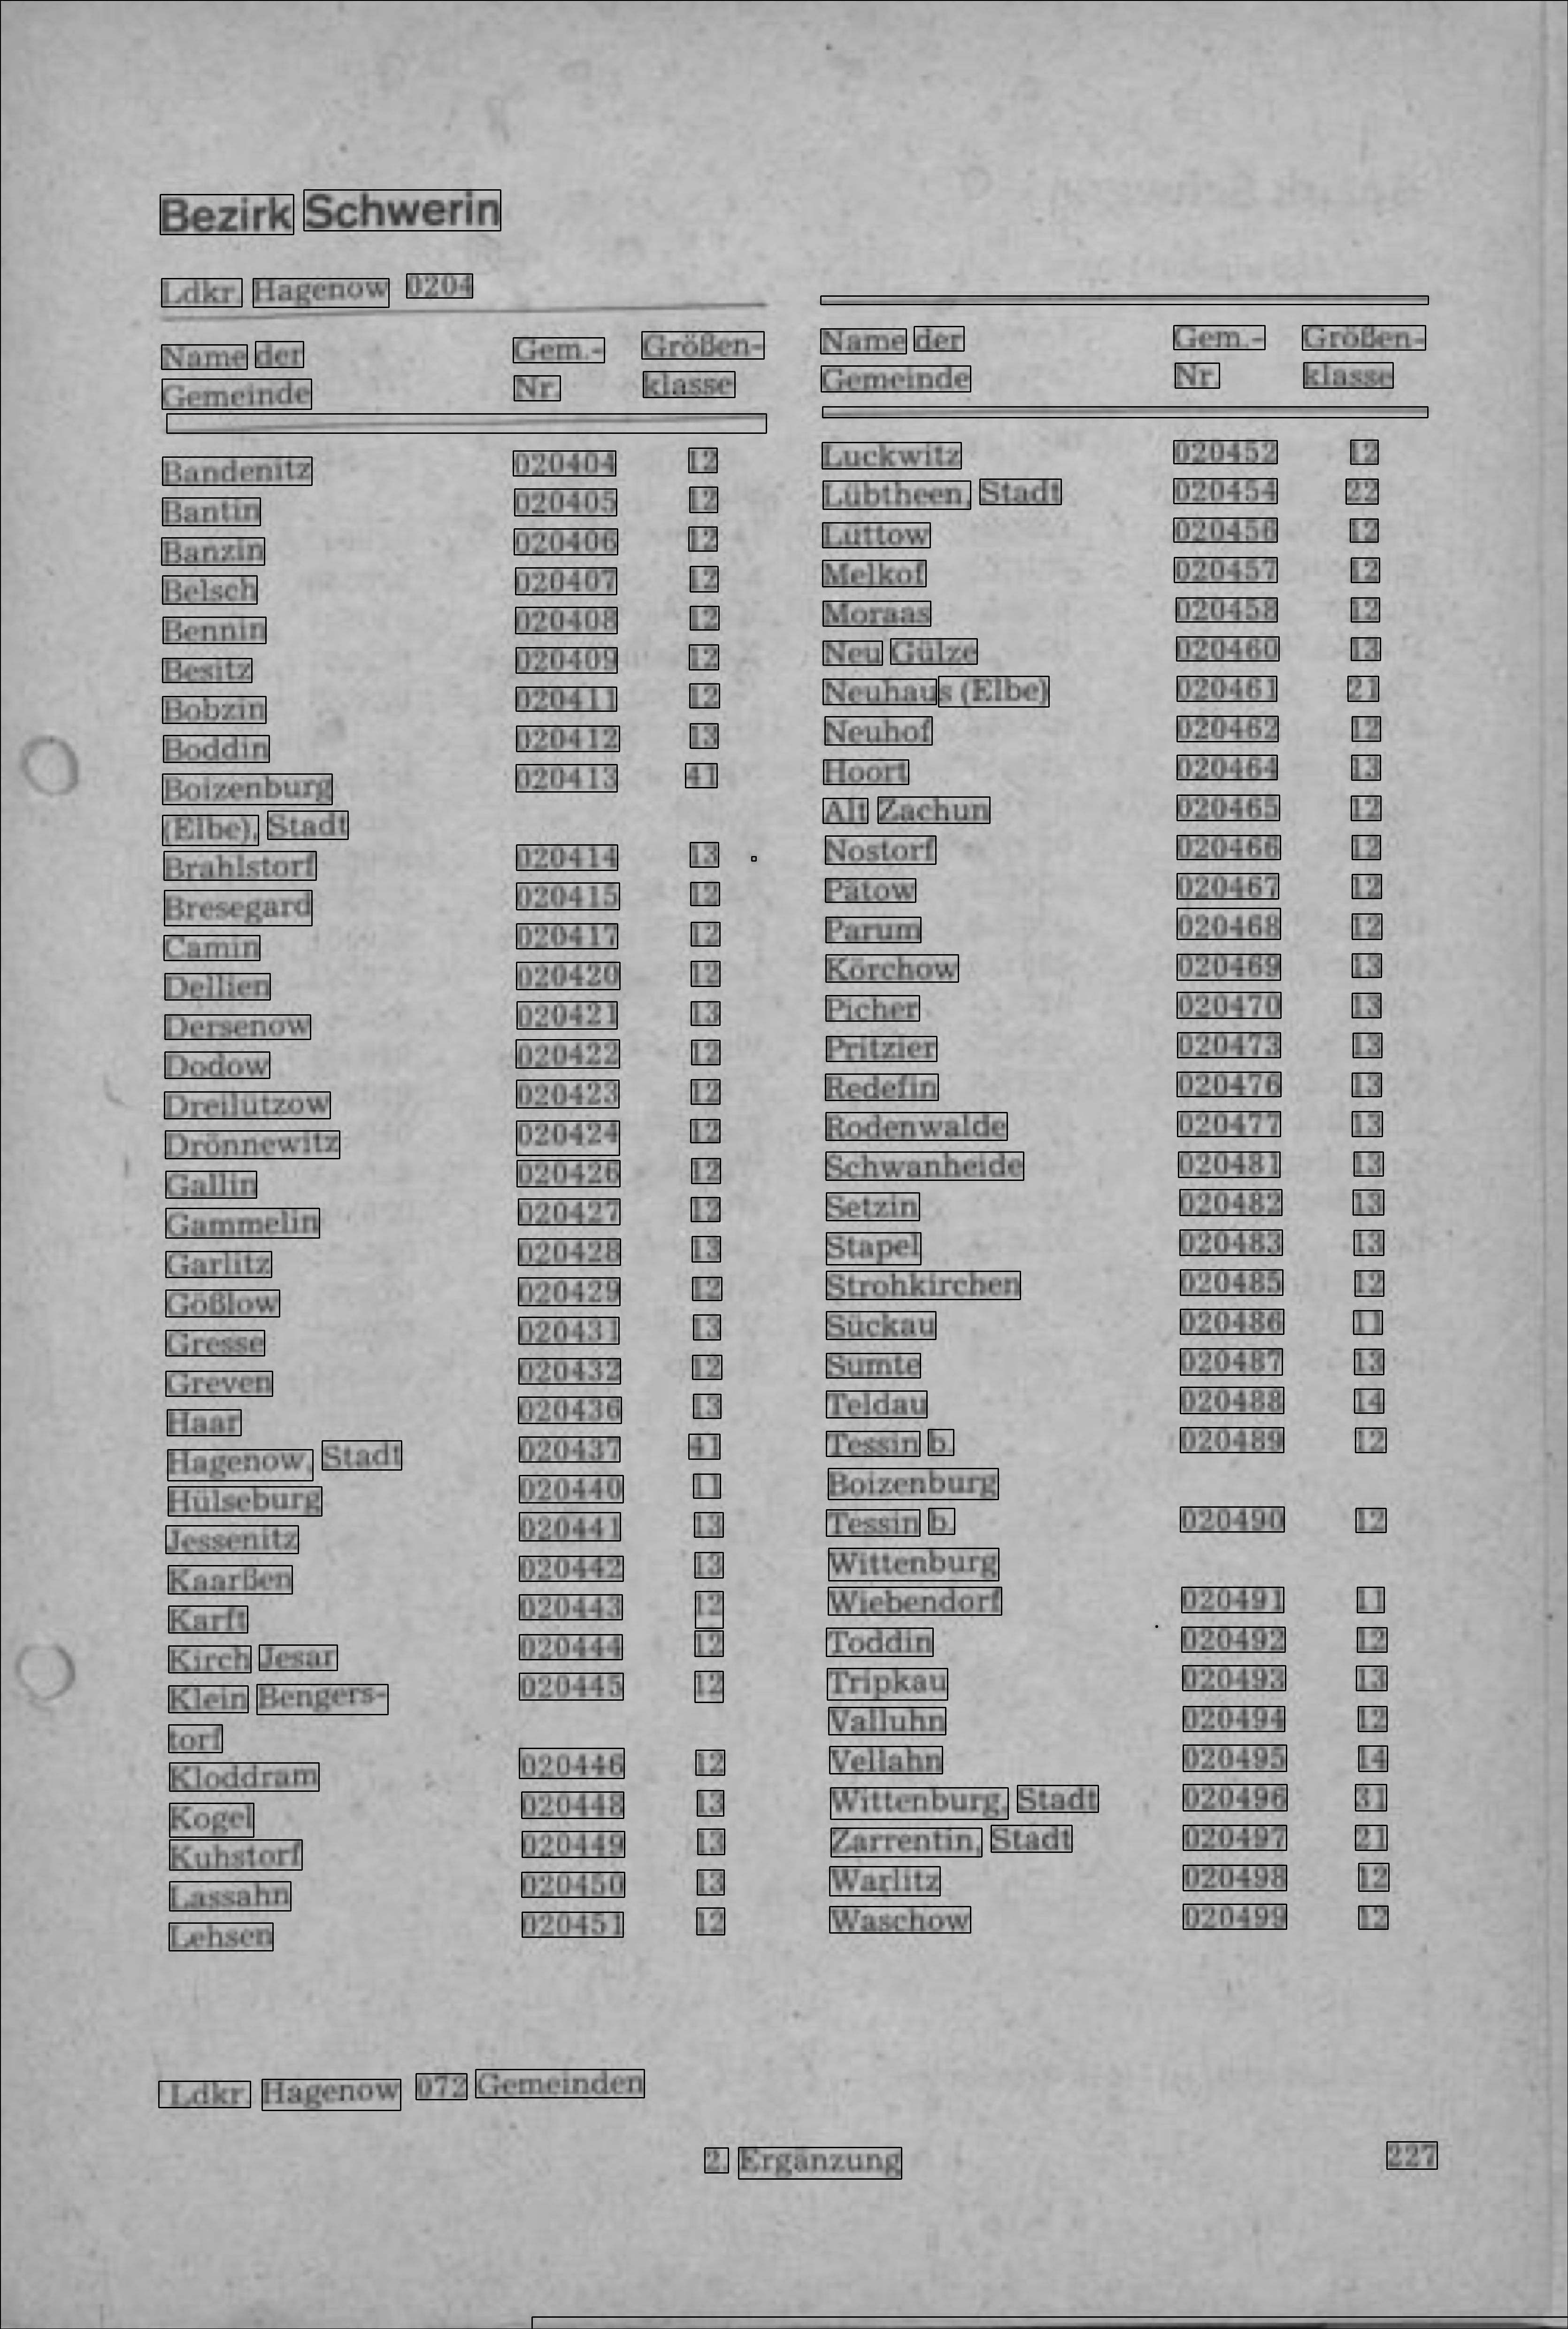

In [122]:
n_boxes = len(ocr['text'])
for i in range(n_boxes):
    if int(ocr['conf'][i]) > 0:
        (x, y, w, h) = (ocr['left'][i], ocr['top'][i], ocr['width'][i], ocr['height'][i])
        img_2 = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(img_2)


In [123]:
#detect rows by y axis position cluster
row_cl = cluster.HierarchicalClustering(ocr['top'], lambda x,y: abs(x-y))
row_cl = row_cl.getlevel(20)

In [124]:
#detect columns by x axis position cluster
col_cl = cluster.HierarchicalClustering(ocr['left'], lambda x,y: abs(x-y))
col_cl = col_cl.getlevel(120)

In [125]:
#sort columns left to right 
col_cl.sort(key = stat.median)

In [126]:
#sort rows top to bottom 
row_cl.sort(key = stat.median)

In [127]:
#get data ids of elements in each col to acces text with 
col_data_ids = []
for i in range(len(col_cl)):
  def condition(x, vals): return x in vals
  col_data_ids.append([idx for idx, element in enumerate(ocr['left']) if condition(element, col_cl[i])])


In [ ]:
[ocr['text'][i] for i in col_data_ids[4]]

In [128]:
#get data ids of elements in each row to acces text with 
row_data_ids = []
for i in range(len(row_cl)):
  def condition(x, vals): return x in vals
  row_data_ids.append([idx for idx, element in enumerate(ocr['top']) if condition(element, row_cl[i])])

In [ ]:
#get text for each row 
[ocr['text'][i] for i in row_data_ids[6]]

In [129]:
#which rows to keep

test_string = ["Gemeinde","Nr","Klasse","Nr.","klasse","Nr,","Gem.","Gem.-"]

test_len = []
for i in range(len(row_data_ids)):
  row_i = [ocr['text'][j] for j in row_data_ids[i]]
  test_len.append(len(list(set(test_string).intersection(row_i))))


In [130]:
#which rows to keep
rows = row_data_ids[(test_len.index(max(test_len)) + 1):]

In [131]:
#which cols to keep

col_string = ["Name","Gemeinde","Nr","Nr.","Nr,","Gem.","Gem.-"]

col_keep = []
for i in range(len(col_data_ids)):
  col_i = [ocr['text'][j] for j in col_data_ids[i]]
  col_keep.append(len(list(set(col_string).intersection(col_i))))


In [132]:
#which cols to keep
cols = [e for i, e in enumerate(col_data_ids) if i in [i for i, e in enumerate(col_keep) if e > 0]]


In [133]:
results_set_1 = []

for i in range(len(rows)):
  row_i = rows[i]
  set_1 = sorted(list(set(row_i).intersection(list(itertools.chain.from_iterable(cols[:2])))))
  set_1 = list(filter(len,[ocr['text'][i] for i in set_1]))
  
  #turn numbers to int
  set_1_h = [int(ele) if ele.isdigit() else ele for ele in set_1]

  #combine strings
  def condition(x): return type(x) == str
  join_id = [idx for idx, element in enumerate(set_1_h) if condition(element)]

  if len(join_id) > 1:
    strings = [' '.join([set_1_h[join_id[0]]] + [set_1_h[index] for index in join_id[1:]])]
    set_1 = strings + [set_1[index] for index in list(set(list(range(len(set_1)))) - set(join_id))]

  #turn into data frame ready format 
  if all(' ' == s or '' == s for s in set_1):
    set_1 = ['','']
  elif all(type(s) == str for s in set_1):
    set_1 = set_1 + ['']
  elif all(s.isdigit() for s in set_1):
    set_1 = [''] + set_1
  else:
    set_1 = set_1

  results_set_1.append(set_1)

In [142]:
results_set_2 = []

for i in range(len(rows)):
  row_i = rows[i]
  set_2 = sorted(list(set(row_i).intersection(list(itertools.chain.from_iterable(cols[2:])))))
  set_2 = list(filter(len,[ocr['text'][i] for i in set_2]))

  #turn numbers to int
  set_2_h = [int(ele) if ele.isdigit() else ele for ele in set_2]

   #combine strings
  def condition(x): return type(x) == str
  join_id = [idx for idx, element in enumerate(set_2_h) if condition(element)]

  if len(join_id) > 1:
    strings = [' '.join([set_2_h[join_id[0]]] + [set_2_h[index] for index in join_id[1:]])]
    set_2 = strings + [set_2[index] for index in list(set(list(range(len(set_2)))) - set(join_id))]

  #turn into data frame ready format 
  if all(' ' == s or '' == s for s in set_2):
    set_2 = ['','']
  elif all(type(s) == str for s in set_2):
    set_2 = set_2 + ['']
  elif all(s.isdigit() for s in set_2):
    set_2 = [''] + set_2
  else:
    set_2 = set_2
  results_set_2.append(set_2)

In [140]:
a = 'ABC'

In [141]:
a.isdigit()

False

In [143]:
results_set_2

[['', ''],
 ['12', 'Luckwitz', '020452', ''],
 ['Lübtheen, Stadt', '12', '020454', ''],
 ['12', 'Lüttow', '020456', ''],
 ['ı2 Melkof', '020457', ''],
 ['12', 'Moraas', '020458', ''],
 ['', ''],
 ['Neu Gülze', '12', '020460', ''],
 ['', ''],
 ['Neuhaus (Elbe)', '12', '020461', ''],
 ['13', 'Neuhof', '020462', ''],
 ['41', 'Hoort', '020464', ''],
 ['Alt Zachun', '020465', ''],
 ['', ''],
 ['» Nostorf', '13', '020468', ''],
 ['12', 'Pätow', '020467', ''],
 ['12', 'Parum', '020468', ''],
 ['', ''],
 ['12', 'Körchow', '020469', ''],
 ['', ''],
 ['13', 'Picher', '020470', ''],
 ['', ''],
 ['12', 'Pritzier', '020473', ''],
 ['', ''],
 ['12', 'Redefin', '020476', ''],
 ['', ''],
 ['12', 'Rodenwalde', '020477', ''],
 ['', ''],
 ['12', 'Schwanheide', '020481', ''],
 ['', ''],
 ['12', 'Setzin', '020482', ''],
 ['13', 'Stapel', '020483', ''],
 ['', ''],
 ['12', 'Strohkirchen', '020485', ''],
 ['', ''],
 ['13', 'Sückau', '020486', ''],
 ['', ''],
 ['12', 'Sumte', '020487', ''],
 ['', ''],
 ['13', 

In [115]:
df_1 = pd.DataFrame (results_set_1, columns = ['town','id'])
df_2 = pd.DataFrame (results_set_2, columns = ['town','id'])
df = df_1.append(df_2)
df

town      id
0                                     
1                               101001
2                  Auma, Stadt  101002
3                    Bernsgrün  101003
4                   Braunsdorf  101004
5                        Dobia  101005
6                   Dörtendorf  101006
7                    Ebersgrün  101007
8                      Förthen  101008
9                Göhren-Döhlen  101009
10                  Göttendorf  101010
11                        Hain  101011
12                Hohenleuben,  101013
13                       Stadt        
14             'Kleinwolschen-  101014
15                        dorf        
16                      Läwitz  101016
17            Langenwetzendorf  101017
18             Langenwolschen-  101018
19                        dorf        
20                    Leitlitz  101019
21                       Mehla  101021
22  Ldkr. Zeulenroda Gemeinden      35
23                                    
0                                     
1                   Merkendorf  101022
2                     Muntscha  101023
3               Niederböhmers-  101024
4                         dorf        
5                       Pahren  101025
6                Pausa/Vogtl.,  101026
7                        Stadt        
8                     Pällwitz  101027
9                     Ranspach  101028
10                  Silberfeld  101030
11                      Staitz  101031
12                    Triebes,  101034
13              Unterreichenau  101035
14                 Weckersdorf  101037
15                  Weißendorf  101038
16                 Wenigenauma  101039
17                 Wiebelsdorf  101040
18                  Zadelsdorf  101042
19                 Zeulenroda,  101043
20                       Stadt        
21                                    
22                                    
23

In [116]:
df.to_csv('ocr_gemeinde_test.csv')

In [118]:
im.save("ocr_og.jpeg")